In [1]:
import datetime 

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import folium 
import geopandas as gpd 
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

current_file_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_file_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from constants.paths import FOLDER_PATH
from load_inputs.systematic_analysis.load_netmob import load_dataset,get_list_apps,get_list_days,get_DL_UL_paths,read_csv,load_netmob_gdf
from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc
from load_inputs.systematic_analysis.utils import preprocess_df

folder_path = f'{FOLDER_PATH}/../raw_data/NetMob/'
shp_iris_path = f'{FOLDER_PATH}/../raw_data/lyon_iris_shapefile/'
path_save = '../../../../../../data/NetMob/NetMob_Lyon'
folder_path = '../../../../../../data/NetMob/NetMob_raw'

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible


# Functions:

In [2]:

def build_df_for_folium_map(df_loaded,Netmob_gdf_joined,filter_q,city = 'Lyon', absolute_max_ref_coeff=0.33,absolute_min_ref_coeff = 0.1, start=None,end=None,period=None,temporal_agg=None):
   
   df = df_loaded.copy()

   # clipping extreme values:
   df_clipped = df_loaded.clip(upper=df_loaded.quantile(0.995), axis=1)

   # Get reference of 'max' summed values:
   absolute_ref_max = df_clipped.sum(0).max()*absolute_max_ref_coeff


   # filter quantile: 
   if period is None: 
      df = preprocess_df(df,filter_q = filter_q,city=city,start=start,end=end,temporal_agg = temporal_agg)
   else:
      df_bd_in, df_nbd_in = preprocess_df(df,period=period,city= city,filter_q = filter_q,start=start,end=end)
      df = pd.concat([df_bd_in,df_nbd_in])

   print('Remaining shape: ',df.shape)


   ts = df.sum(0)

   df_map = Netmob_gdf_joined.merge(ts.rename('volume'), on='tile_id').to_crs(epsg=4326)

   # Drop row where volume < 0.05*max 
   absolute_ref_min = absolute_min_ref_coeff*absolute_ref_max
   df_map = df_map[df_map['volume']>=absolute_ref_min]
   return df_map,absolute_ref_max,absolute_ref_min


def plot_heatmap_folium(df_map,app,absolute_ref_min,absolute_ref_max,
                        cmap = 'YlOrRd',
                        period = None,
                        start = None,
                        end = None,
                        filter_q = None):
     
    centroids = df_map.geometry.centroid
    m = folium.Map(location=[centroids.y.mean(), centroids.x.mean()], zoom_start=11,tiles = 'CartoDB positron')

    rounded_df_map = df_map.copy()
    rounded_df_map['volume'] = (rounded_df_map['volume']/1e6).round(1)
    m = rounded_df_map.explore(m=m, 
                column='volume',
                    cmap=cmap, 
                    legend=True, 
                    vmin = (absolute_ref_min/1e6).round(1), # df_map['volume'].min(),
                    vmax = (absolute_ref_max/1e6).round(1), # df_map['volume'].quantile(0.99),
                    style_kwds={'fillOpacity':0.7, 'weight':0.0,
                                'opacity':0.2,
                                },
                    legend_kwds={'caption': f'Absolute Intensity (Million) - {app} - {period+" - " if period is not None else ""}{start.strftime("%H:%M") if start is not None else ""} to {end.strftime("%H:%M") if end is not None else ""}',
                                'colorbar': True
                                },
                    )
    # save m:
    folder_save = f"{os.getcwd()}/load_inputs/systematic_analysis/plots"
    m.save(f'{folder_save}/{app}_{period+"_" if period is not None else ""}E{start.strftime("%H%M") if start is not None else ""}-E{end.strftime("%H%M") if end is not None else ""}_q{filter_q if filter_q is not None else ""}.html')
    return m


# Analyse Signal 

In [3]:
df_summed_signal = pd.DataFrame()
for app in ['Deezer','Google_Maps','Web_Weather']:
    # ['Instagram','Snapchat','Facebook_Messenger','WhatsApp','Deezer','Spotify','Google_Maps','Uber','Web_Weather',
    #         ]:
    # Load Datasets:
    data = np.load(f'{path_save}/{app}.npy')
    idx = pd.read_pickle(f'{path_save}/index.pkl')
    cols = pd.read_pickle(f'{path_save}/columns.pkl')

    df_loaded = pd.DataFrame(data, index=idx, columns=cols)
    ts = df_loaded.sum(1)
    df_summed_signal[app] = ts
print(df_summed_signal.head())


                          Deezer  Google_Maps  Web_Weather
2019-03-16 00:00:00  165163204.0   24696176.0    2646275.0
2019-03-16 00:15:00  178654812.0   21915118.0    3414444.0
2019-03-16 00:30:00  125104102.0   21817044.0    2447842.0
2019-03-16 00:45:00  103515366.0   21833612.0    2484113.0
2019-03-16 01:00:00  117259692.0   22420648.0    2234372.0


'df_normalized head:'

,Deezer,Google_Maps,Web_Weather
2019-03-16 00:00:00,0.226178,0.321530,0.155203
2019-03-16 00:15:00,0.244653,0.285322,0.200256
2019-03-16 00:30:00,0.171320,0.284046,0.143565
2019-03-16 00:45:00,0.141756,0.284261,0.145692
2019-03-16 01:00:00,0.160578,0.291904,0.131045


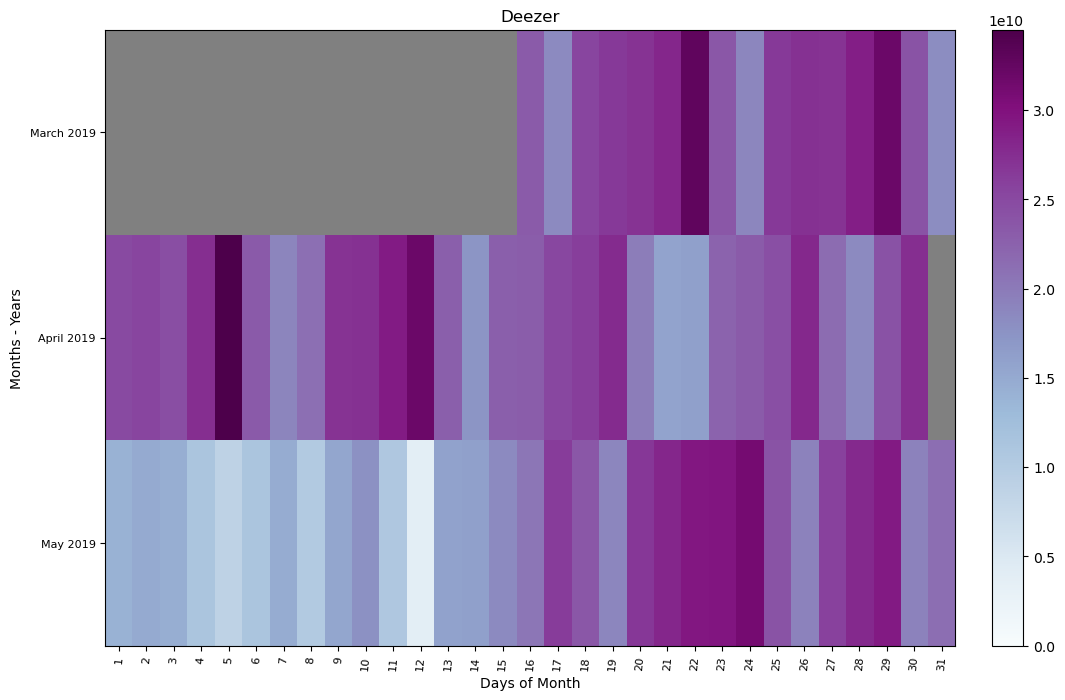

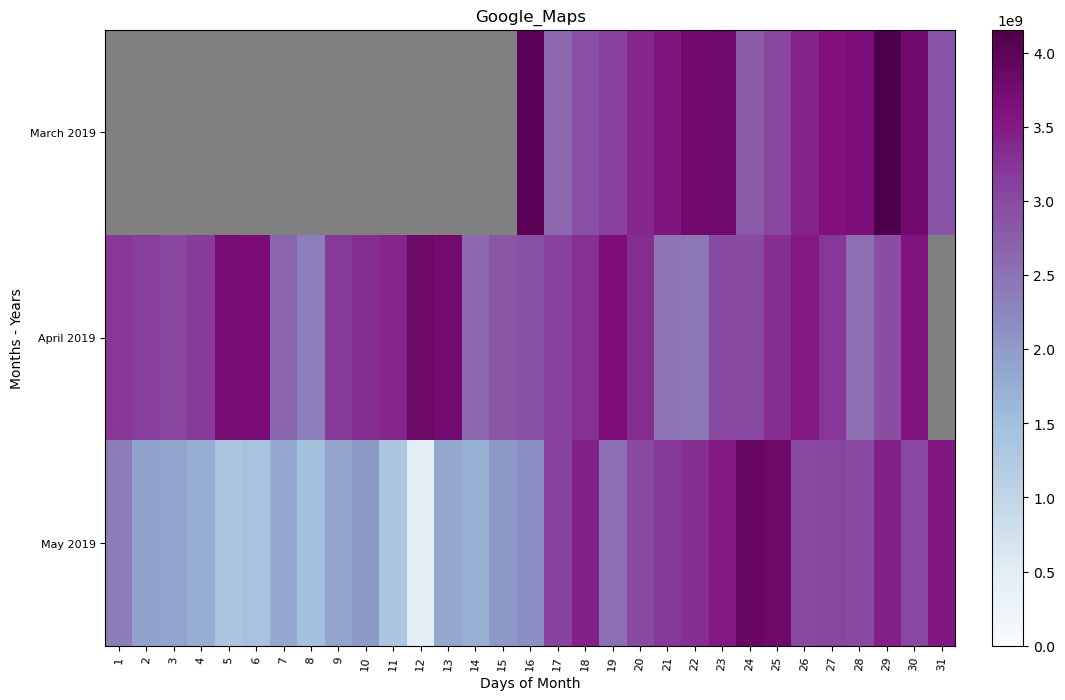

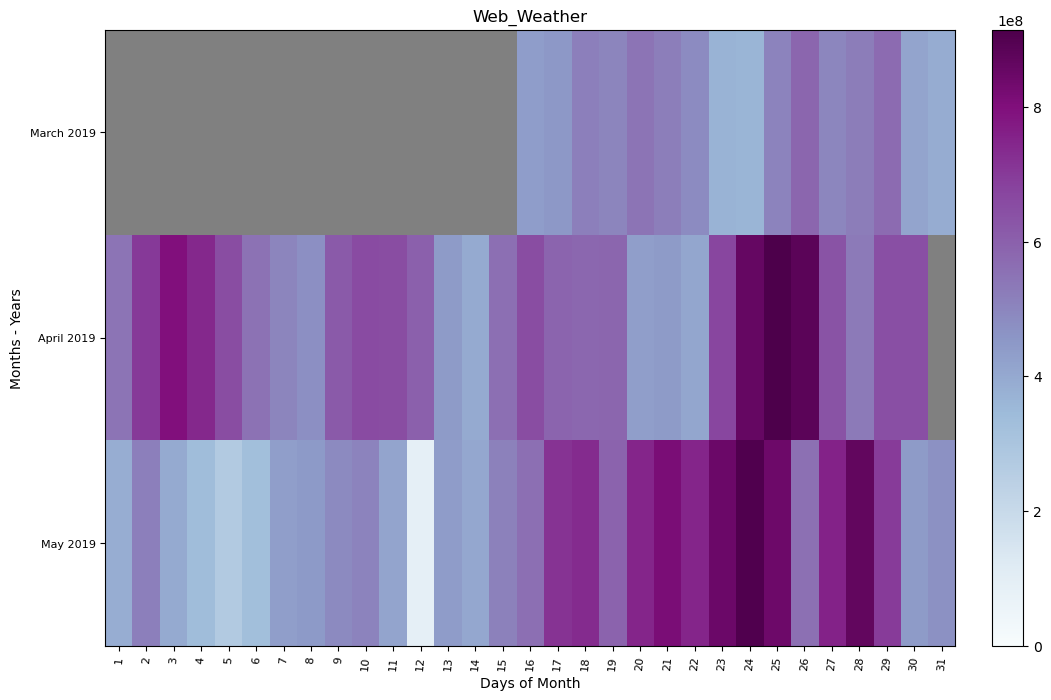

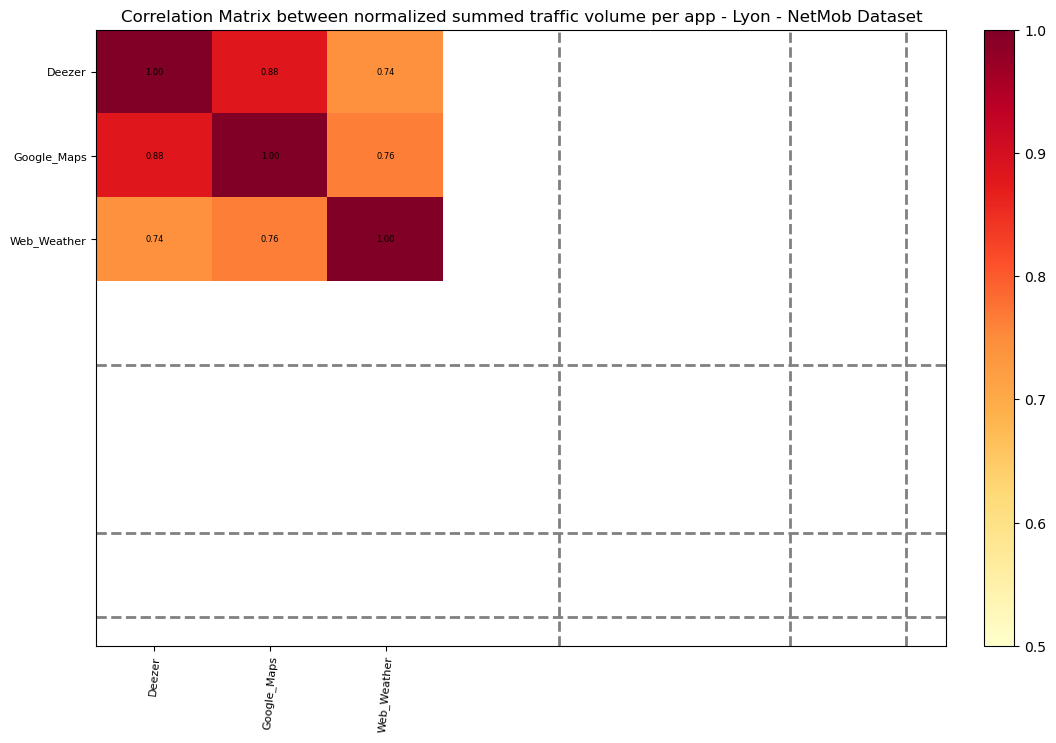

Loading BokehJS ...

figure(id='p1001', ...)

In [4]:
from load_inputs.systematic_analysis.utils import heatmap
from pipeline.plotting.plotting import plot_coverage_matshow
import matplotlib.pyplot as plt
figsize = (12,8)
apps = ['Deezer','Google_Maps','Web_Weather'] # ['Instagram','Snapchat','Facebook_Messenger','Spotify','Deezer','WhatsApp','Google_Maps','Uber','Web_Weather']
df_summed_signal_copy = df_summed_signal[apps]
# clip extreme values & Normalize
df_clipped = df_summed_signal_copy.clip(upper=df_summed_signal_copy.quantile(0.995), axis=1)
df_normalized = df_clipped / df_clipped.max()
display('df_normalized head:')
display(df_normalized.head())
# Plot heatmap Volume & Missing period  
folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/netmob_heatmap"
for app in apps:
    save_path = f'{folder}/{app}_heatmap.pdf'
    df_agg = heatmap(df_clipped[[app]],figsize = figsize,city = 'Lyon',bool_reversed = False,cmap = 'BuPu',title = app,save_path = save_path)

# Plot Correlatino Matrix between time-series:

df_corr = df_normalized.corr()
# cmap='RdYlBu'
cmap ="YlOrRd"
folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots"
ax = plot_coverage_matshow(df_corr,cmap=cmap, save=None,
                           bool_reversed=False, 
                           v_min=0.5, v_max=1, 
                           display_values=True, 
                           cbar_magic_args = True,
                           figsize = figsize,
                        )

title = f"Correlation Matrix between normalized summed traffic volume per app - Lyon - NetMob Dataset"
ax.set_title(title)
# Set white dashed horizontal and vertical lines to separate groups of apps at position 4,6, and 7:
ax.axhline(y=4-0.5, color='gray', linestyle='--', linewidth=2)
ax.axhline(y=6-0.5, color='gray', linestyle='--', linewidth=2)
ax.axhline(y=7-0.5, color='gray', linestyle='--', linewidth=2)
ax.axvline(x=4-0.5, color='gray', linestyle='--', linewidth=2)
ax.axvline(x=6-0.5, color='gray', linestyle='--', linewidth=2)
ax.axvline(x=7-0.5, color='gray', linestyle='--', linewidth=2)

# save plot: 
save_path = f'{folder}/netmob_corr.pdf'
plt.savefig(save_path, bbox_inches='tight')

plt.show()


# Plot : 
from pipeline.plotting.TS_analysis import plot_TS

plot_TS(list_df_ts=df_normalized,width = 1200,height=400,bool_show= True,
        title = 'Normalized summed traffic volume per app - Lyon - NetMob Dataset',
        )

# Plot Daily Profile

In [9]:
from load_inputs.systematic_analysis.utils import preprocess_df
df_bd, df_nbd = preprocess_df(df_normalized,ascending=None,period= 'all_day',city= 'Lyon')

mean_df_bd,std_df_bd = df_bd.groupby(df_bd.index.time).mean(),df_bd.groupby(df_bd.index.time).std()

x_axis_label = 'Hour of the day'
y_axis_label = 'Normalized traffic volume'
plot_TS(list_df_ts=mean_df_bd,width = 1200,height=400,bool_show= True,
        title = 'Daily profile of normalized app consumption across Lyon',
        only_hours= True,
        std_band= std_df_bd,
        x_axis_label= x_axis_label,
        y_axis_label= y_axis_label
)


Number of remaining time-slots after filtering 4896
Number of remaining time-slots after filtering 2496


Loading BokehJS ...

figure(id='p1310', ...)

# Load Spatial Dataset

In [22]:
Netmob_gdf_joined,working_zones,n_rows,n_cols = load_netmob_gdf(folder_path,shp_iris_path)
Netmob_gdf_joined = Netmob_gdf_joined.drop_duplicates('tile_id')
Netmob_gdf_joined = Netmob_gdf_joined[['tile_id','INSEE_COM','NOM_COM','NOM_IRIS','geometry']]
Netmob_gdf_joined = gpd.GeoDataFrame(Netmob_gdf_joined,crs='EPSG:4326') #Don't know why, but the geodataframe seem corrupted as we can't convert it into GeoJson, that's why we need to use "gpd.GeoDataFrame()"
print('Shape gdf: ',Netmob_gdf_joined.shape)
Netmob_gdf_joined.head()  

ERROR 1: PROJ: proj_create_from_database: Open of /root/anaconda3/envs/pytorch-2.0.1/share/proj failed


Shape gdf:  (27446, 5)


,tile_id,INSEE_COM,NOM_COM,NOM_IRIS,geometry
5067,34807,69204.0,Saint-Genis-Laval,Basses Barolles,"POLYGON ((4.78896 45.66473, 4.78900 45.66563, ..."
5194,35094,69204.0,Saint-Genis-Laval,Basses Barolles,"POLYGON ((4.78900 45.66563, 4.78904 45.66653, ..."
5195,35095,69204.0,Saint-Genis-Laval,Basses Barolles,"POLYGON ((4.79028 45.66560, 4.79032 45.66650, ..."
5196,35096,69204.0,Saint-Genis-Laval,Basses Barolles,"POLYGON ((4.79156 45.66557, 4.79160 45.66647, ..."
5328,35380,69204.0,Saint-Genis-Laval,Basses Barolles,"POLYGON ((4.78776 45.66656, 4.78780 45.66745, ..."


# Load Raw data:

In [6]:
""" Choices: 

['Apple_Video', 'Google_Play_Store', 'Google_Maps', 'Web_Clothes', 'Uber', 'Twitter', 'Microsoft_Mail', 'Microsoft_Store', 'Apple_Music', 'Microsoft_Office', 'Pokemon_GO', 'Clash_of_Clans', 'Yahoo_Mail', 'PlayStation', 'Wikipedia', 'Apple_Web_Services', 'Pinterest', 'Web_Ads', 'Google_Mail', 'Google_Meet', 'Apple_Siri', 'Web_Adult', 'Spotify', 'Deezer', 'Waze', 'Web_Games', 'Apple_App_Store', 'Microsoft_Skydrive', 'Google_Docs', 'Microsoft_Web_Services', 'Molotov', 'YouTube', 'Apple_iTunes', 'Apple_iMessage', 'DailyMotion', 'Netflix', 'Web_Transportation', 'Web_Downloads', 'SoundCloud', 'TeamViewer', 'Google_Web_Services', 'Facebook', 'EA_Games', 'Tor', 'Amazon_Web_Services', 'Web_e-Commerce', 'Telegram', 'Apple_Mail', 'Dropbox', 'Web_Food', 'Apple_iCloud', 'Skype', 'Facebook_Messenger', 'Twitch', 'Microsoft_Azure', 'Instagram', 'Facebook_Live', 'Web_Streaming', 'Orange_TV', 'Periscope', 'Snapchat', 'Web_Finance', 'WhatsApp', 'Web_Weather', 'Google_Drive', 'LinkedIn', 'Yahoo', 'Fortnite']
"""


filter_q = 0.99 # None


dict_time_periods = {'Night_time':{
                           'start' : datetime.time(23,0,0),
                           'end' : datetime.time(6,0,0),
                           'period' : None, # 'business_day'
                           'temporal_agg' : None, # None # 'business_day' # non_business_day
                        },
                     'Morning_Peak':{
                           'start' : datetime.time(6,30,0),
                           'end' : datetime.time(10,30,0),
                           'period' : None, # 'business_day'
                           'temporal_agg' : 'business_day' # None # 'business_day' # non_business_day
                        },
                     'Evening_Peak':{
                           'start' : datetime.time(16,30,0),
                           'end' : datetime.time(20,0,0),
                           'period' : None, # 'business_day'
                           'temporal_agg' : 'business_day' # None # 'business_day' # non_business_day
                        },
                     'All_day':{
                           'start' : datetime.time(6,30,0),
                           'end' :datetime.time(23,30,0),
                           'period' : None, # 'business_day'
                           'temporal_agg' : 'business_day' # None # 'business_day' # non_business_day
                        },
                        }


# app = 'Instagram' # 'Deezer' # 'Spotify' # 'Web_Weather' # 'Instagram' # 'Google_Maps' # 'WhatsApp' 

for app in ['Deezer','Spotify','Google_Maps','WhatsApp','Uber','Web_Weather']:
    # Load Datasets:
    data = np.load(f'{path_save}/{app}.npy')
    idx = pd.read_pickle(f'{path_save}/index.pkl')
    cols = pd.read_pickle(f'{path_save}/columns.pkl')

    df_loaded = pd.DataFrame(data, index=idx, columns=cols)
    print(df_loaded.shape)

    for key,value in dict_time_periods.items():
        start,end,period,temporal_agg = value['start'],value['end'],value['period'],value['temporal_agg']
        
        df_map,absolute_ref_max,absolute_ref_min = build_df_for_folium_map(df_loaded,Netmob_gdf_joined.copy(),filter_q,city = 'Lyon',
                                                        absolute_max_ref_coeff=0.33,
                                                        absolute_min_ref_coeff = 0.1,
                                                        start=start,end=end,
                                                        period=period,
                                                        temporal_agg=temporal_agg
                                                        )
        
        # HeatMap:
        m = plot_heatmap_folium(df_map,app,
                            absolute_ref_max=absolute_ref_max, 
                            absolute_ref_min = absolute_ref_min,
                            cmap = 'YlOrRd',
                            period=period,
                            start=start,
                            end=end,
                            filter_q=filter_q
                            )
        # ---
        m



(7392, 27446)
Number of remaining time-slots after filtering 2233
Remaining shape:  (2233, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 867
Remaining shape:  (867, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 765
Remaining shape:  (765, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 3519
Remaining shape:  (3519, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


(7392, 27446)
Number of remaining time-slots after filtering 2233
Remaining shape:  (2233, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 867
Remaining shape:  (867, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 765
Remaining shape:  (765, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 3519
Remaining shape:  (3519, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


(7392, 27446)
Number of remaining time-slots after filtering 2233
Remaining shape:  (2233, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 867
Remaining shape:  (867, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 765
Remaining shape:  (765, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 3519
Remaining shape:  (3519, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


(7392, 27446)
Number of remaining time-slots after filtering 2233
Remaining shape:  (2233, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 867
Remaining shape:  (867, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 765
Remaining shape:  (765, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 3519
Remaining shape:  (3519, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


(7392, 27446)
Number of remaining time-slots after filtering 2233
Remaining shape:  (2233, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 867
Remaining shape:  (867, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 765
Remaining shape:  (765, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 3519
Remaining shape:  (3519, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


(7392, 27446)
Number of remaining time-slots after filtering 2233
Remaining shape:  (2233, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 867
Remaining shape:  (867, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 765
Remaining shape:  (765, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


Number of remaining time-slots after filtering 3519
Remaining shape:  (3519, 27446)


/tmp/ipykernel_24659/2237438829.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = df_map.geometry.centroid


## Load data aggregated by tags (ex: IRIS)


NetMob_selected_apps= ['Google_Maps'] 
NetMob_transfer_mode = ['DL'] 
NetMob_selected_tags = ['iris']
NetMob_expanded = ''
NetMob_only_epsilon = False
city = 'Lyon'
signal = 'netmob_POIs'
ds, df_raw, df = load_dataset(signal,
            NetMob_selected_apps,
            NetMob_transfer_mode,
            NetMob_selected_tags,
            NetMob_expanded,
            NetMob_only_epsilon,
            )
df_raw.columns.name = 'Spatial Unit ID'
df_raw.head()